# Zero-Shot Text Classification

Text classification, also known as text tagging or text categorization, is the process of categorizing text into organized groups. Using Natural Language Processing (NLP), text classifiers can automatically analyze text and then assign a set of pre-defined tags or categories based on its content. For example, the emails received go through a text classification task of filtering spam vs. non-spam emails. Social media platforms use text classification to determine whether comments should be flagged as inappropriate.

The goal of this tutorial is to:

 * Introduce you to text classification with Zero-Shot Learning
 * learn to write custom python functions to evaluate our model
 * Get your hands dirty with coding experiments to improve our model performance.

Along the way, we will go through the Forte pipeline and learn how well it integrates with other third-party libraries like `HuggingFace` and `NLTK`.

Before looking at this tutorial, we first need to appreciate the broad scope of this topic.

## Introduction
In general, most machine learning-based modeling involves these three important steps :

 * Data gathering and processing
 * Modeling
 * Evaluation

However, the gathered data is very low to train a deep neural network(`DNN`) model in some cases. In such cases, we generally use a pre-trained `DNN` model trained on some large dataset, and then we 'fine-tune' the model on our dataset. This kind of modeling is called transfer learning. And Zero-Shot text classification is an extreme example of transfer learning, where the model tries to classify without any fine-tuning on a single data. This kind of model uses the similarity between the input text and label name to decide the class based on the highest similarity score. So this method does not need any labeled data. Well-defined Label names are sufficient to achieve good performance.

## Dataset

For this tutorial, we will be using a subset of the publicly available amazon review sentiment [ARS](https://s3.amazonaws.com/fast-ai-nlp/amazon_review_polarity_csv.tgz) dataset. Let's do some exploration of our sample data. You can also use the complete dataset by downloading it from the link above.

### Data Visualization

We will use the Pandas library to read the CSV file and visualize the input data. There are three columns in the input CSV file.

 * Labels with value 1 are considered Negative, and value 2 are considered Positive.
 * Title as a short title to the review.
 * Body is the complete description of the review.
 
We can use either of them as our text input to build our classifier.

In [1]:
import pandas as pd
# if you want to change your input file, you can change it below.
csv_path = "../../data_samples/amazon_review_polarity_csv/amazon_sample_20.csv"
# to use the full width of the notebook, lets set the columnwidth to 150
pd.set_option('display.max_colwidth', 130)
df=pd.read_csv(csv_path)
print('size of the data : ',df.shape)
df.sample(5)

size of the data :  (20, 3)


,label,Title,Body_Description
6,2,Great Music,I generally hate it when singers attempt to sing '60's and '70's Motown that were not a part of the Organization during that e...
11,1,Useful but Advanced Tech. for Java Developers is better.,Advanced Tech. for Java Developers contains in one chapter what this book drags out. But ATFJD also gives you good info on Bea...
7,1,Dont order from worldofbookusa!,It has been a month since I ordered this book from worldofbookusa and I still have not received it. I'm sure the book is great...
0,1,One year on and overheated and failed,"Fine until a year later the mouse pointer stopping and starting on the screen. I noticed the hub was hot, unplugged and let it..."
10,1,Worst Logitech mouse ever. Save your $ for a nicer model,Save your money and buy a better Logitech mouse than this. They should be embarrassed at the LOW quality of this mouse. The ba...


Let's also check the class balance of the data by using `groupby` and count functions in pandas. The sample data is unbalanced significantly, so even if our model predicts label '1' for any input, our accuracy will be 14/(14+6) = 70%. So the base accuracy of our model should be at least greater than 70%.

       Title  Body_Description
label                         
1         14                14
2          6                 6


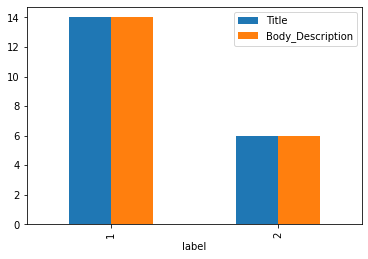

In [2]:
dfc=df.groupby('label').count()
print(dfc)
dfc.plot(kind='bar').legend(loc=1)

Let's print two random samples from the Body_Description column. We can find that the text sample has multiple sentences. So we will split each text sample into individual sentences using `NLTKSentenceSegmenter`.

In [3]:
print('sample A : \n',df['Body_Description'][11],'\n')
print('sample B : \n',df['Body_Description'][15])

sample A : 
 Advanced Tech. for Java Developers contains in one chapter what this book drags out. But ATFJD also gives you good info on Beans, Servlets, JNI ... . If some one gives you a copy of Java RMI you will get something out of it, but buy the other one. I bought both (sigh). 

sample B : 
 Got this movie as part of a box set. Best thing about the movie is that it is less than 90 minutes long.


Forte pipeline will help us manage the flow of operations needed to make our predictions. 

 * The first component in our pipeline will be the data reader, using [ClassificationDatasetReader](https://github.com/asyml/forte/blob/bd20b54203dd2083e3d401a55f44d6d7b690bed6/forte/data/readers/classification_reader.py).
 * The second component will be the sentence segmentation model from [NLTKSentenceSegmenter](https://github.com/asyml/forte-wrappers/blob/main/src/nltk/fortex/nltk/nltk_processors.py#:~:text=class%20NLTKSentenceSegmenter(PackProcessor))
 * The Third component will be our text classifier [ZeroShotClassifier](https://github.com/asyml/forte-wrappers/blob/7c2fd5d21fbc3cd4c66596c2182b8299e2ce6a86/src/huggingface/fortex/huggingface/zero_shot_classifier.py#:~:text=class%20ZeroShotClassifier(PackProcessor))

In [4]:
from forte.pipeline import Pipeline
from forte.data.readers import ClassificationDatasetReader
from fortex.nltk import NLTKSentenceSegmenter
from fortex.huggingface import ZeroShotClassifier

Defining class names and converting them into a numerical representation. We have to keep in mind to select very meaningful class names for this kind of modeling. We will later see how the definition of class names changes the accuracy of our model.

In [5]:
class_names = ["negative", "positive"]
index2class = dict(enumerate(class_names))

`cuda_device`: Device ordinal for CPU/GPU supports. Setting
              this to -1 will leverage CPU, a positive will run the model
              on the associated CUDA device id.

In [6]:
cuda_device=0 # -1 for cpu

You can also select the name of the pre-trained model from [HuggingFace](https://huggingface.co/models?pipeline_tag=zero-shot-classification)

In [7]:
model_name="valhalla/distilbart-mnli-12-1" # i.e, "facebook/bart-large-mnli", "joeddav/bart-large-mnli-yahoo-answers"

Let's put everything into the Forte pipeline.

In [8]:
pl = Pipeline()
pl.set_reader(ClassificationDatasetReader(), config={"index2class": index2class})
pl.add(NLTKSentenceSegmenter())
pl.add(ZeroShotClassifier(), config={"candidate_labels": class_names,
                                     "model_name": model_name ,
                                     "cuda_device":cuda_device})
pl.initialize();

[nltk_data] Downloading package punkt to
[nltk_data]     /home/bhaskar.rao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Prediction
We will predict a sentence from the description column using the above pipeline. We can see that the `NLTKSentenceSegmenter` has split the text in each input row into individual sentences. Then `ZeroShotClassifier` is making predictions for each sentence. The number beside the Label name is the confidence score for the prediction is made.

In [9]:
from ft.onto.base_ontology import Sentence
from ft.onto.base_ontology import Document
from termcolor import colored

In [10]:
for pack in pl.process_dataset(csv_path):
    print(colored('Original Text : ',"magenta"),'\n',pack.text,'\n')
    for sent in pack.get(Sentence):
        sent_text = sent.text
        print(colored("Sentence:", "red"), sent_text)
        print(colored("Prediction:", "blue"), sent.classification, "\n")
    print('-----------------------------------------------------------')
    break

Original Text :  
 One year on and overheated and failed
Fine until a year later the mouse pointer stopping and starting on the screen. I noticed the hub was hot, unplugged and let it cool and start again. The problem then started more frequently and the unit became very hot. Had to toss it in the end. Won't buy Belkin again. 

Sentence: One year on and overheated and failed
Fine until a year later the mouse pointer stopping and starting on the screen.
Prediction: {'negative': 0.8738, 'positive': 0.0285} 

Sentence: I noticed the hub was hot, unplugged and let it cool and start again.
Prediction: {'positive': 0.0924, 'negative': 0.0363} 

Sentence: The problem then started more frequently and the unit became very hot.
Prediction: {'negative': 0.2644, 'positive': 0.0011} 

Sentence: Had to toss it in the end.
Prediction: {'negative': 0.9785, 'positive': 0.0075} 

Sentence: Won't buy Belkin again.
Prediction: {'negative': 0.9985, 'positive': 0.0837} 

------------------------------------

## Evaluation
We can predict at sentence level now. Moreover, from the above example, it seems our model is doing very well. However, we need to evaluate our model with some metrics like accuracy to assess the quality in a quantifiable manner. Before that, we need to aggregate our sentence-level prediction to text level. Let's write an aggregate function.

### Aggregate

In order to aggregate our sentence predictions, we can average the confidence scores of each sentence in a text input. So let's define a function that will take the `pack` object and return the average confidence score of sentences in the `pack` text.

In [11]:
def aggregate_class_score(pack):
    ''' aggregates class scores
    input: pack object
    output: returns average class score of sentences in the pack.text
    '''
    prediction_list=[] 
    avg_score={}
    count_sentences=0
    for sent in pack.get(Sentence):
        for i in sent.classification.items():
            try:
                avg_score[i[0]]=avg_score[i[0]]+i[1]
            except:
                avg_score[i[0]]=i[1]
        count_sentences+=1
        
    for i in avg_score.keys():
        avg_score[i]=avg_score[i]/count_sentences
        
    return avg_score

Let's write a small script to check our text prediction vs. ground truth and also save our results for evaluating accuracy.

In [12]:
y_true=[]
y_pred=[]
for c,pack in enumerate(pl.process_dataset(csv_path)):
    yt=next(pack.get(Document)).document_class[0]
    avg_score=aggregate_class_score(pack)
    yp=pd.DataFrame.from_dict(avg_score,orient ='index')[0].idxmax()
    ys=avg_score[yp] 
    y_true.append(yt)
    y_pred.append(yp)
    
    if c%8==0:
        print(colored('Original Text : ',"magenta"),'\n',pack.text,'\n')
        #print(pack.text,'\n')
        print(colored('ground_truth : ','green'),
              yt,colored('     predicted_class : ','blue'),
              yp,colored(' confidence score : ','red'),ys,'\n')

Original Text :  
 One year on and overheated and failed
Fine until a year later the mouse pointer stopping and starting on the screen. I noticed the hub was hot, unplugged and let it cool and start again. The problem then started more frequently and the unit became very hot. Had to toss it in the end. Won't buy Belkin again. 

ground_truth :  negative      predicted_class :  negative  confidence score :  0.6303 

Original Text :  
 Dont order from worldofbookusa!
It has been a month since I ordered this book from worldofbookusa and I still have not received it. I'm sure the book is great but the supplier is not. 

ground_truth :  negative      predicted_class :  negative  confidence score :  0.6373333333333333 

Original Text :  
 Kung Fu Vampires
Got this movie as part of a box set. Best thing about the movie is that it is less than 90 minutes long. 

ground_truth :  negative      predicted_class :  positive  confidence score :  0.5896 



### Accuracy
We will use the [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html?highlight=accuracy#sklearn.metrics.accuracy_score) library to evaluate accuracy. In the previous block, we stored the ground truth and prediction in two lists. `accuracy_score` from `sklearn` will take these as input and return the model's accuracy.

In [13]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true, y_pred)

0.8571428571428571

## Experiment
Here we will explore ways to improve the accuracy of our model on a given dataset. As we know, the Zero_Shot model makes predictions based on the similarity between the input sentence and the class names. So we can experiment with different class names similar to the original class names and find out which class names work best for our dataset. So let's write a function that combines all the above necessary steps to conduct this experiment.

In [14]:
def accuracy(csv_path,Label_1='negative',Label_2='positive',model_name='valhalla/distilbart-mnli-12-1',cuda_device=0):
    '''This function unifies the initialization, prediction and accuracy evaluation.
    input : csv_path and class names
    output : accuracy'''
    class_names = [Label_1, Label_2]
    index2class={0:Label_1,1: Label_2}
    
    pl = Pipeline()
    pl.set_reader(ClassificationDatasetReader(), config={"index2class": index2class})
    pl.add(NLTKSentenceSegmenter())
    pl.add(ZeroShotClassifier(), config={"candidate_labels": class_names,
                                         "model_name": model_name ,
                                         "cuda_device":cuda_device})
    pl.initialize();

    y_true=[]
    y_pred=[]
    for c,pack in enumerate(pl.process_dataset(csv_path)):
        yt=next(pack.get(Document)).document_class[0]
        avg_score=aggregate_class_score(pack)
        yp=pd.DataFrame.from_dict(avg_score,orient ='index')[0].idxmax()
        ys=avg_score[yp] 
        y_true.append(yt)
        y_pred.append(yp)
    return accuracy_score(y_true, y_pred)

In [15]:
accuracy(csv_path,Label_1='unsatisfied',Label_2='satisfied',model_name='valhalla/distilbart-mnli-12-1',GPU=0)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/bhaskar.rao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0.9

In [16]:
accuracy(csv_path,Label_1='unsatisfied',Label_2='satisfied',model_name='facebook/bart-large-mnli',GPU=0)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/bhaskar.rao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartForSequenceClassification: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0.95

Accuracy of 95% on unseen data is an exceptional performance from the Hugging-Face model. Zero-Shot learning is a powerful tool for low volume of label data. With an intelligent selection of class names, we can improve further. We can see that class names ('unsatisfied', 'satisfied') improved our accuracy by 5% compared to class names ('negative', 'positive'). 

## HomeWork
Your task is to define a list of similar class names grouped into tuples. Keep the order of the class names to be similar too. i.e., first the negative word, then the positive word. Add at least five extra pairs of class names to the list below.

In [ ]:
class_name_list=[('negative','positive'),
                ('unsatisfied','satisfied')
                ]

In [ ]:
class_name=[]
accuracy_list=[]
for i in class_name_list:
    class_name.append(i[0]+'_'+i[1])
    accuracy_list.append(accuracy(csv_path,Label_1=i[0],Label_2=i[1]))
da=pd.DataFrame()
da['class_name']=class_name
da['accuracy']=accuracy_list
da

You can also try different pretrained models from [HuggingFace](https://huggingface.co/models?pipeline_tag=zero-shot-classification) and find out which models perform better than others on your dataset.